# ADA Project : Milestone 2

## Imports and Data

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
# Data from RateBeer 'RB'
beers_RB = pd.read_table("./data/RateBeer/beers.csv", sep=",")
breweries_RB = pd.read_table("./data/RateBeer/breweries.csv", sep=",")
users_RB = pd.read_table("./data/RateBeer/users.csv", sep=",")
ratings_RB = pd.read_table("./data/RateBeer/ratings.csv", sep=",")

In [ ]:
# Data from BeerAdvocate 'BA'
beers_BA = pd.read_table("./data/BeerAdvocate/beers.csv", sep=",")
breweries_BA = pd.read_table("./data/BeerAdvocate/breweries.csv", sep=",")
users_BA = pd.read_table("./data/BeerAdvocate/users.csv", sep=",")
ratings_BA = pd.read_table("./data/BeerAdvocate/ratings.csv", sep=",")

In [ ]:
# Data from BA and RB mixed (by us)
# ratings_mixed = pd.read_table("./data/ratings_BAm_RBm.csv", sep=",")
ratings_mixed_sample = pd.read_table("./data/ratings_BAm_RB_sample.csv", sep=",")

In [ ]:
# Data from MixedDataset 'MD'
beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
breweries_MD = pd.read_table("./data/matched_beer_data/breweries.csv", sep=",")
users_MD = pd.read_table("./data/matched_beer_data/users.csv", sep=",")
users_approx_MD = pd.read_table("./data/matched_beer_data/users_approx.csv", sep=",")
ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")

## Seasonal analysis of the number of reviews per type of beer

In [ ]:
import datetime as dt

# create sub_dataframe with type of beer and date
df_count_type_season = df[['type','date']].dropna()

# create extra column with the day in year corresponding to the date
df_count_type_season['day_of_year'] = df_count_type_season['date'].dt.dayofyear

num_bins = 10
bins = 365/num_bins * np.range(1, num_bins + 1)
groups = df.groupby(['type', pd.cut(df.day_of_year, bins)])
print(groups.size().unstack())
groups.plot(type='line')

exit()

# for loop on the different type of beer
types = pd.unique(df_count_type_season['type'])

plt.figure(figsize=(5,5))
for beertype in types:
    df_count = df_count_type_season[df_count_type_season['type'] == beertype][day_of_year].group_by('day_of_year').count()
    print(df_count.iloc[:5])
    
    # count per day (or broader bins)
    # plot

## Number of review per day using rolling average

In [ ]:


# Assuming the file is named 'beer_ratings.csv' and is located in the same directory as your script.
# Read the CSV file
BA_NR_RW_DAY=ratings_BA
# Convert the Unix time to a datetime object, assuming the 'date' column is Unix time in seconds
BA_NR_RW_DAY['date'] = pd.to_datetime(BA_NR_RW_DAY['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later
BA_NR_RW_DAY_WW = BA_NR_RW_DAY[(BA_NR_RW_DAY['date'] >= start_date) & (BA_NR_RW_DAY['date'] <= end_date)]


In [ ]:
# Group by the date and count the reviews
def plot_rolling(df, window=7):
    daily_reviews = df.groupby(df['date'].dt.date).size()
    print(daily_reviews)
    # Calculate the moving average with a window size of 7 to remove weeks days
    rolling = daily_reviews.rolling(window=window, center=True)
    rolling_average = rolling.mean()
    
    # Plot the rolling average
    plt.figure(figsize=(14, 7))
    rolling_average.plot(title='Number of Reviews Per Day Over One Year')
    
    # Add labels and grid
    plt.xlabel('Date')
    plt.ylabel('Average Number of Reviews')
    plt.grid(True)
    plt.show()
plot_rolling(BA_NR_RW_DAY_WW)

In [ ]:
german_beers= ratings_BA[ratings_BA["brewery_id"].isin(breweries_BA[breweries_BA['location']=='Germany']['id'])]
german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_beers_WW = german_beers[(german_beers['date'] >= start_date) & (german_beers['date'] <= end_date)]
plot_rolling(german_beers_WW)

In [ ]:
german_users= ratings_BA[ratings_BA["user_id"].isin(users_BA[users_BA['location']=='Germany']['user_id'])]
#german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_users_WW = german_users[(german_users['date'] >= start_date) & (german_users['date'] <= end_date)]
plot_rolling(german_users_WW, 7)

## Alcohol by volume evolution in a mean year by country of user

In [66]:
alcohol_reviews = ratings_mixed_sample[['date','user_location','abv']]
alcohol_reviews = alcohol_reviews.dropna()

alcohol_reviews.loc[:,'date'] = alcohol_reviews[['date']].apply(lambda x: pd.to_datetime(x, unit='s'))
alcohol_reviews.loc[:,'time'] = alcohol_reviews.loc[:,'date'].apply(lambda x: x.year)
alcohol_reviews = alcohol_reviews.drop(columns = "date")
alcohol_reviews = alcohol_reviews[alcohol_reviews.groupby('user_location')['user_location'].transform('size') > 50000]
alcohol_reviews

,user_location,abv,time
1,"United States, New York",4.5,2009
10,"United States, Pennsylvania",4.8,2013
11,"United States, California",4.8,2013
13,"United States, New York",4.8,2013
16,"United States, Pennsylvania",4.8,2012
...,...,...,...
15516810,Denmark,4.0,2015
15516811,Denmark,4.0,2015
15516812,Denmark,4.0,2015
15516814,Denmark,4.0,2015


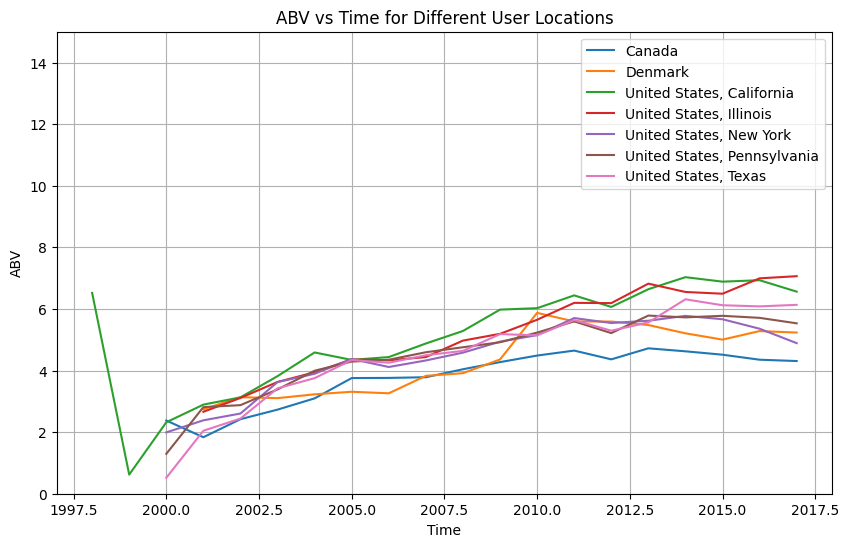

In [73]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()

# Create a plot with multiple lines and legend
plt.figure(figsize=(10, 6))

for location in mean_abv["user_location"].unique():
    location_data = mean_abv[mean_abv["user_location"] == location]
    plt.plot(location_data["time"], location_data["abv"], label=location)

plt.xlabel("Time")
plt.ylabel("ABV")
plt.ylim([0, 15])
plt.legend(loc="upper right")
plt.title("ABV vs Time for Different User Locations")
plt.grid(True)
plt.show()

user_location
Canada                         [[Axes(0.125,0.11;0.775x0.77)]]
Denmark                        [[Axes(0.125,0.11;0.775x0.77)]]
United States, California      [[Axes(0.125,0.11;0.775x0.77)]]
United States, Illinois        [[Axes(0.125,0.11;0.775x0.77)]]
United States, New York        [[Axes(0.125,0.11;0.775x0.77)]]
United States, Pennsylvania    [[Axes(0.125,0.11;0.775x0.77)]]
United States, Texas           [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

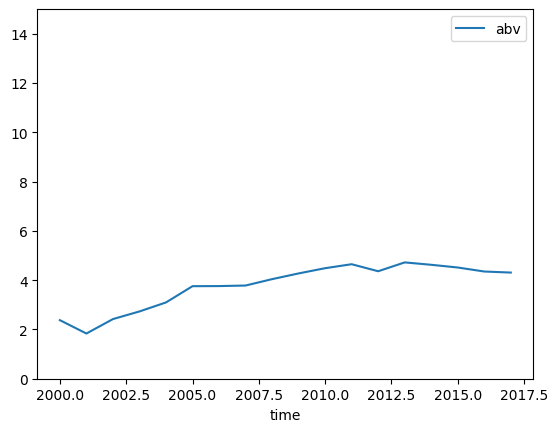

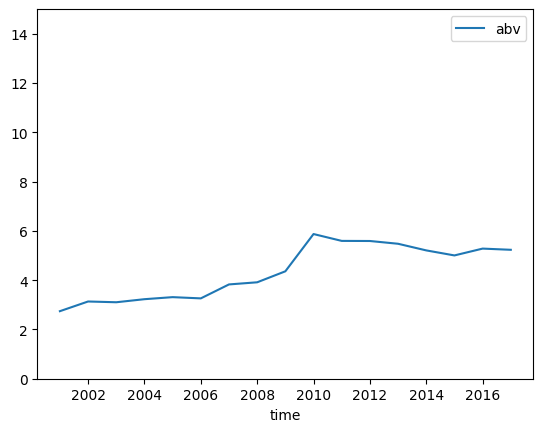

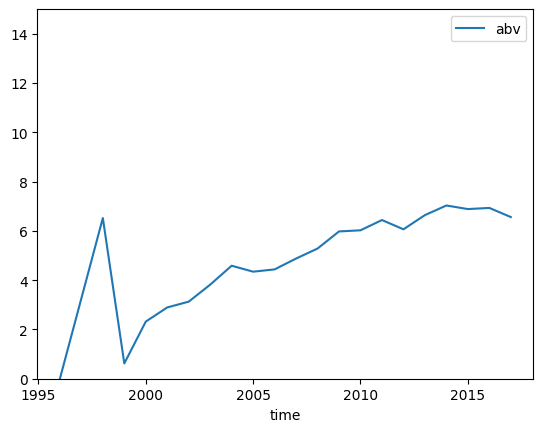

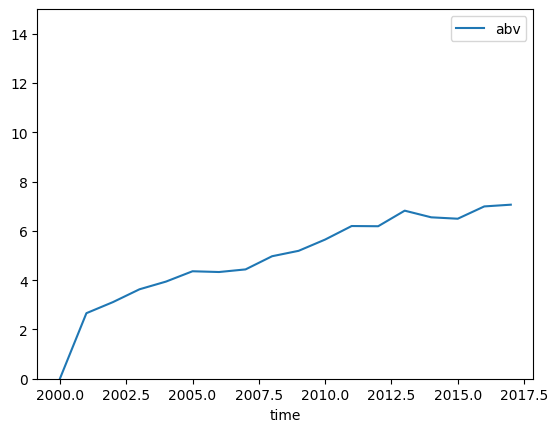

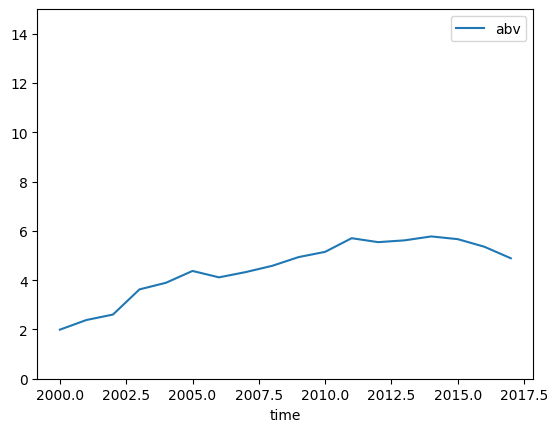

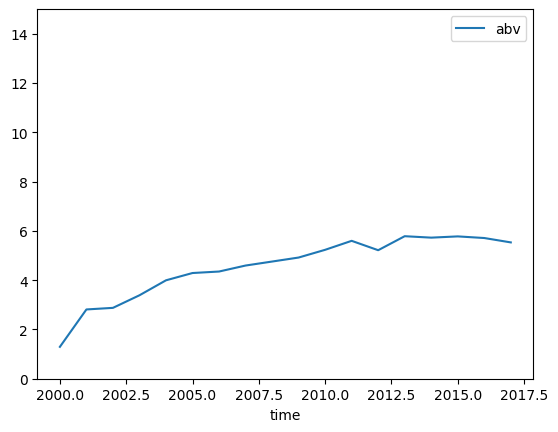

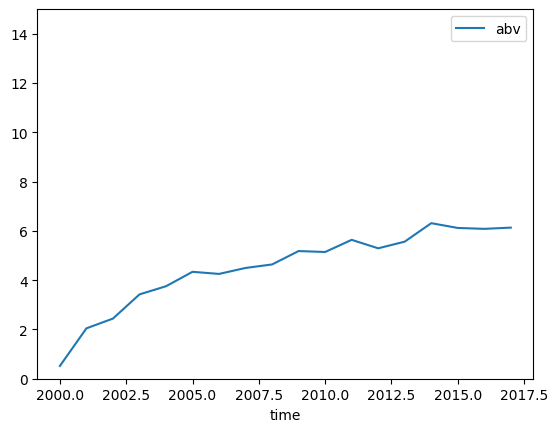

In [72]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()
mean_abv.groupby("user_location").plot(x="time", y='abv', kind='line', ylim=[0, 15], subplots=True, sharex=False, sharey=True, layout= (1, -1), stacked=True, use_index=True)

<Axes: xlabel='time'>

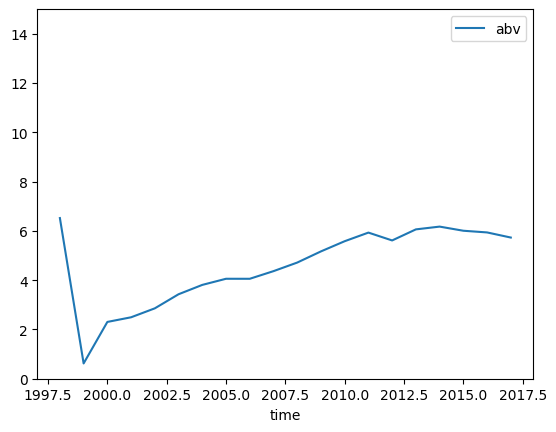

In [71]:
alcohol_reviews_global = alcohol_reviews.drop(columns='user_location')
mean_abv = alcohol_reviews_global.groupby(["time"]).var().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15])

<Axes: xlabel='time'>

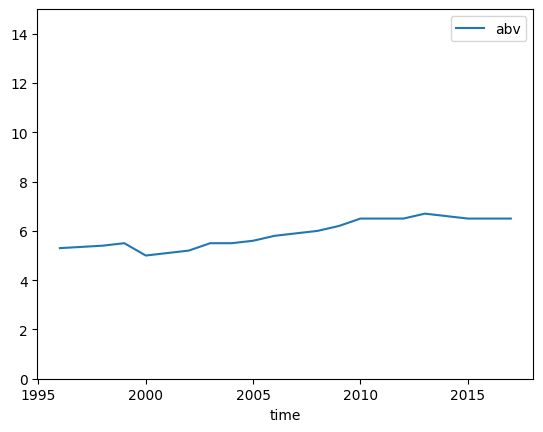

In [55]:
mean_abv = alcohol_reviews.groupby(["time"]).median().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

<Axes: xlabel='time'>

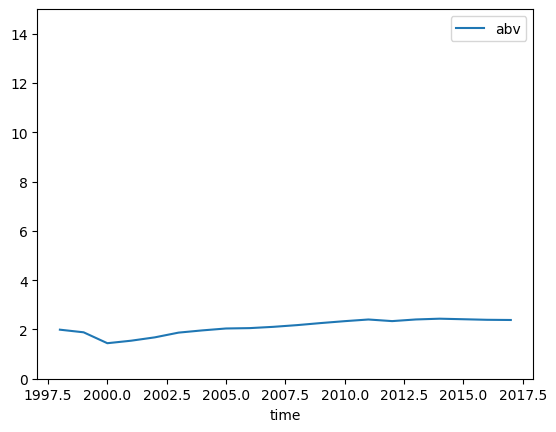

In [56]:
mean_abv = alcohol_reviews.groupby(["time"]).std().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

## Analysis 4